In [1]:
# General imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
import sys
from PIL import Image
from mpl_toolkits.mplot3d import axes3d, Axes3D

# Tensorflow
import tensorflow as tf

# Keras imports
from keras.layers import Input, Dense, Lambda, Conv1D, Flatten, Reshape, BatchNormalization, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras import metrics
from keras import losses
from keras import initializers
from keras.datasets import mnist
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from keras import optimizers

# Os.path
from os.path import exists, join, abspath
from os import makedirs, getcwd


# Windows short path
import win32api

# Interactive plotting
import PyQt5
%matplotlib qt5
# # Plot inline
# %matplotlib inline

Using TensorFlow backend.


# Data Generation
We will be using the same sinusoid data from previous experiments. We generate the data and save it in memory due to its simplicity. 

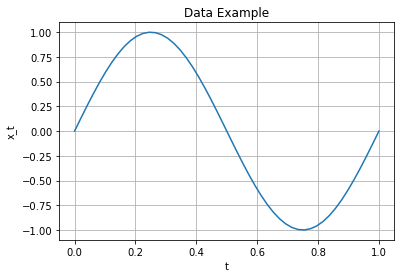

In [2]:
num_phases = 100
time_samples = 50
omega_value = 2*np.pi
# Phases used
phase_range = 2*np.pi*np.linspace(0,1,num_phases)
time_range = np.linspace(0,1,time_samples)
# Signals
signals = np.sin(np.subtract.outer(phase_range,-(omega_value * time_range)))
%matplotlib inline
plt.plot(time_range, signals[0])
plt.xlabel('t')
plt.ylabel('x_t')
plt.title("Data Example")
plt.grid()

### VAE Parameters
This part of code determines the batch size, the dimensions of the latent space, the intermediate dimensions for the hidden layers


In [3]:
batch_size = 100
latent_dim = 1
intermediate_dim = int(time_samples/3)
epsilon_std = 1.0
filters = 64
kernel_size = 3

### Heat Kernel Parameters
The heat kernel parameters determine the distribution of the encoder distribution. 
\begin{equation}
q(z|\boldsymbol{x}^{(i)},\mu_z,t) = \frac{1}{2L}+\frac{1}{L}\sum_{n = 1}^{\infty} \text{cos}\left(\frac{n\pi}{L}(z-\mu_z)\right)e^{-\left(\frac{n\pi}{L}\right)^2t}
\end{equation}

 - **L:** This is the value of the periodic boundary limits $[-L,L]$ where $u(-L,t) = u(L,t) \forall t$
 - **N:** The number of frequencies taken for the Fourier expansion of the solutions. The higher the number, the more accurate but also more expensive computation-wise.
 - **log_t:** In this setting, the time is fixed to a certain value. We use log_t since apparently for calculations this is useful if we compare it to other examples. 

In [4]:
L = 1.0
N = 1000
log_t = -10.0

# VAE

In [26]:
# VAE Encoder
def projection(args):
    z_mean = args
    x_projection = tf.cos(tf.scalar_mul(np.pi, z_mean))
    y_projection = tf.sin(tf.scalar_mul(np.pi, z_mean))
    projection = tf.concat([x_projection, y_projection], axis = -1)
    return projection

def sampling(args):
    z_mean = args 
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0.0, stddev=epsilon_std)
    g_epsilon = tf.mod(z_mean+L+tf.scalar_mul(np.exp(log_t),epsilon),2*L)-L
    return g_epsilon




input_signal = Input(shape=(time_samples,), name='input_signal')
# reshape_input = Reshape(target_shape=(time_samples,1))(input_signal)
# c1 = Conv1D(filters, kernel_size, strides=1,activation='relu', name='c1')(reshape_input)
# c2 = Conv1D(filters, kernel_size, strides=1,activation='relu', name='c2')(c1)
# c3 = Conv1D(filters, kernel_size, strides=1,activation='linear', name='c3')(c2)
h1 = Dense(intermediate_dim, activation = 'relu', name = 'h1')(input_signal)
h2 = Dense(intermediate_dim, activation = 'relu', name = 'h2')(h1)
# flatten = Flatten()(c3)
z_mean = Dense(latent_dim, name='z_mean', activation='linear')(h2)
z_mean_proj = Lambda(projection, output_shape=(2,), name='z_mean_proj')(z_mean)
encoder1D = Model(input_signal, z_mean)
encoder2D = Model(input_signal, z_mean_proj)

z = Lambda(sampling, output_shape=(latent_dim,), name='sampling')(z_mean)
z_proj = Lambda(projection, output_shape=(2,), name='z_proj')(z)

# VAE Decoding
hd1_layer = Dense(intermediate_dim, activation = 'relu', name = 'hd1')
hd2_layer = Dense(time_samples, activation = 'relu', name = 'hd2')
reconstruct_layer = Dense(time_samples, activation = 'linear', name = 'reconstructed')

hd1 = hd1_layer(z_proj)
hd2 = hd2_layer(hd1)
reconstructed = reconstruct_layer(hd2)

vae = Model(input_signal,reconstructed)

# Decoder
_z = Input(shape=(latent_dim,), name='decoder_input')
zproj_ = Lambda(projection, output_shape=(2,), name='zproj_')(_z)
_hd1 = hd1_layer(zproj_)
_hd2 = hd2_layer(_hd1)
_reconstructed = reconstruct_layer(_hd2)
decoder = Model(_z,_reconstructed)


In [27]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_signal (InputLayer)    (None, 50)                0         
_________________________________________________________________
h1 (Dense)                   (None, 16)                816       
_________________________________________________________________
h2 (Dense)                   (None, 16)                272       
_________________________________________________________________
z_mean (Dense)               (None, 1)                 17        
_________________________________________________________________
sampling (Lambda)            (None, 1)                 0         
_________________________________________________________________
z_proj (Lambda)              (None, 2)                 0         
_________________________________________________________________
hd1 (Dense)                  (None, 16)                48        
__________

### Loss Functions
When $L = \pi$ then the variational lower bound can be approximated by :

\begin{equation*}
\mathcal{L}(\theta,\phi,x^{i})\approx \frac{1}{L}\sum_{i=1}^{L} -\frac{3}{2}\text{log}(2\pi)-\frac{\left\lVert\boldsymbol{x}-\boldsymbol{\mu}\right\rVert^{2}}{2}+ \text{log}\left( \frac{1}{2\pi}+\sum_{n = 1}^{\infty} \text{cos}\left(n(z-\mu_z)\right)e^{-n^2t} \right)
\end{equation*}

The first constant term is ignored, the second term corresponds to the MSE and the third is the term related to the encoder. It is calculated by approximating the heat kernel value. 

In [46]:
def xent_loss(x, xr):
    xent_loss = K.mean(losses.mean_squared_error(x, xr))
    return xent_loss

def heat_loss(x, xr):
    # Range for the sum of the Fourier expansion
    sum_range = tf.range(1,N+1,dtype = np.float32)
    sum_range_t = tf.reshape(sum_range,[latent_dim,N])
    # Fourier sum terms
    position = tf.scalar_mul(np.pi/L,z_mean-z) #Position 
    cosine = tf.cos(tf.matmul(position, sum_range_t))
    # Temporal term
    quadratic_term = tf.pow(tf.scalar_mul(np.pi/L,sum_range),2)
    exponent = tf.scalar_mul(-tf.exp(log_t),quadratic_term)
    exponential = tf.exp(exponent)
    # Series sum from n = 1 to N
    summand = tf.multiply(cosine,exponential)
    return tf.log(tf.abs((1/(2*L))+(1/L)*tf.reduce_sum(summand,axis=-1)))

def vae_loss(x, x_decoded_mean):
    return xent_loss(x, x_decoded_mean)+heat_loss(x, x_decoded_mean)


In [47]:
parameters_vae = {"optimizer":optimizers.RMSprop(lr=0.00001,
                                                 rho=0.9,
                                                 epsilon=None,
                                                 decay=0.0),
                 "loss":vae_loss, 
                 "metrics":[xent_loss, heat_loss]}
vae.compile(**parameters_vae)

### Saving experiment files

In [48]:
# File naming variables
experiment_name = 'HeatKernelProjected' # Code for the experiment
timestr = time.strftime("%Y-%m-%d-%H-%M_") # Timestamp
extra_comments ='SimplifiedNtwkProjection' # Extra comments of the experiment




# Folder for saving the different models
folder_models = join(getcwd(),'models', experiment_name)
if not exists(folder_models):
    makedirs(folder_models)
    
# Folder for the generator, the encoder and the vae models. Also tensorboard
folder_dictionary = {'generator':join(folder_models,'generator'),
                    'encoder':join(folder_models,'encoder'),
                    'encoder_sigma':join(folder_models,'encoder_sigma'),
                    'vae':join(folder_models,'vae'),
                    'tensorboard':join(folder_models,'tensorboard'),
                    'images':join(folder_models,'images')}
for folder in folder_dictionary:
    if not exists(folder_dictionary[folder]):
        makedirs(folder_dictionary[folder])
        
log_dir_tensorboard =join(win32api.GetShortPathName(folder_dictionary['tensorboard']),timestr, extra_comments)
print(win32api.GetShortPathName(folder_dictionary['tensorboard']))

C:\Users\LUISPR~1\DOCUME~1\Master\TUE\FINALP~1\Gitlab\vae\models\HEATKE~1\TENSOR~1


In [49]:
reduce_lr = ReduceLROnPlateau(monitor = 'xent_loss',
                              factor = 0.5,
                              patience = 20,
                              mode = 'min',
                              epsilon = 0.000001)

tbCallback = TensorBoard(log_dir =log_dir_tensorboard)

vae.fit(signals, signals,
                  epochs=10000,
                  batch_size=batch_size,
                  callbacks=[tbCallback],
                  validation_data=None, shuffle = False)

# Save the trained models 
experiment_instance = timestr+extra_comments
vae.save_weights(join(folder_models, experiment_instance+'.h5'))
decoder.save(join(folder_dictionary['generator'], experiment_instance))
encoder.save(join(folder_dictionary['encoder'], experiment_instance))
#encoder_sigma.save(join(folder_dictionary['encoder_sigma'], experiment_instance))
vae.save(join(folder_dictionary['vae'], experiment_instance))

Epoch 1/10000
100/100 [==============================] - 0s 2ms/step - loss: 3.7351 - xent_loss: 6.1047e-04 - heat_loss: 3.7345
Epoch 2/10000
100/100 [==============================] - 0s 65us/step - loss: 3.7351 - xent_loss: 6.0346e-04 - heat_loss: 3.7345
Epoch 3/10000
100/100 [==============================] - 0s 85us/step - loss: 3.7351 - xent_loss: 6.0075e-04 - heat_loss: 3.7345
Epoch 4/10000
100/100 [==============================] - 0s 115us/step - loss: 3.7351 - xent_loss: 5.9933e-04 - heat_loss: 3.7345
Epoch 5/10000
100/100 [==============================] - 0s 85us/step - loss: 3.7351 - xent_loss: 5.9918e-04 - heat_loss: 3.7345
Epoch 6/10000
100/100 [==============================] - 0s 70us/step - loss: 3.7351 - xent_loss: 5.9954e-04 - heat_loss: 3.7345
Epoch 7/10000
100/100 [==============================] - 0s 55us/step - loss: 3.7351 - xent_loss: 6.0011e-04 - heat_loss: 3.7345
Epoch 8/10000
100/100 [==============================] - 0s 80us/step - loss: 3.7351 - xent_loss:

NameError: name 'encoder' is not defined

# Evaluation

In [53]:
# Reconstruction testing
predictions = vae.predict(signals, batch_size = batch_size)
# Encoding generation
x_train_encoded_projected = encoder2D.predict(signals, batch_size=batch_size)
x_train_encoded = encoder1D.predict(signals, batch_size=batch_size)
# x_train_encoded_sigma = encoder_sigma.predict(signals, batch_size=batch_size)
# x_train_decoded = decoder.predict(x_train_encoded, batch_size = batch_size)

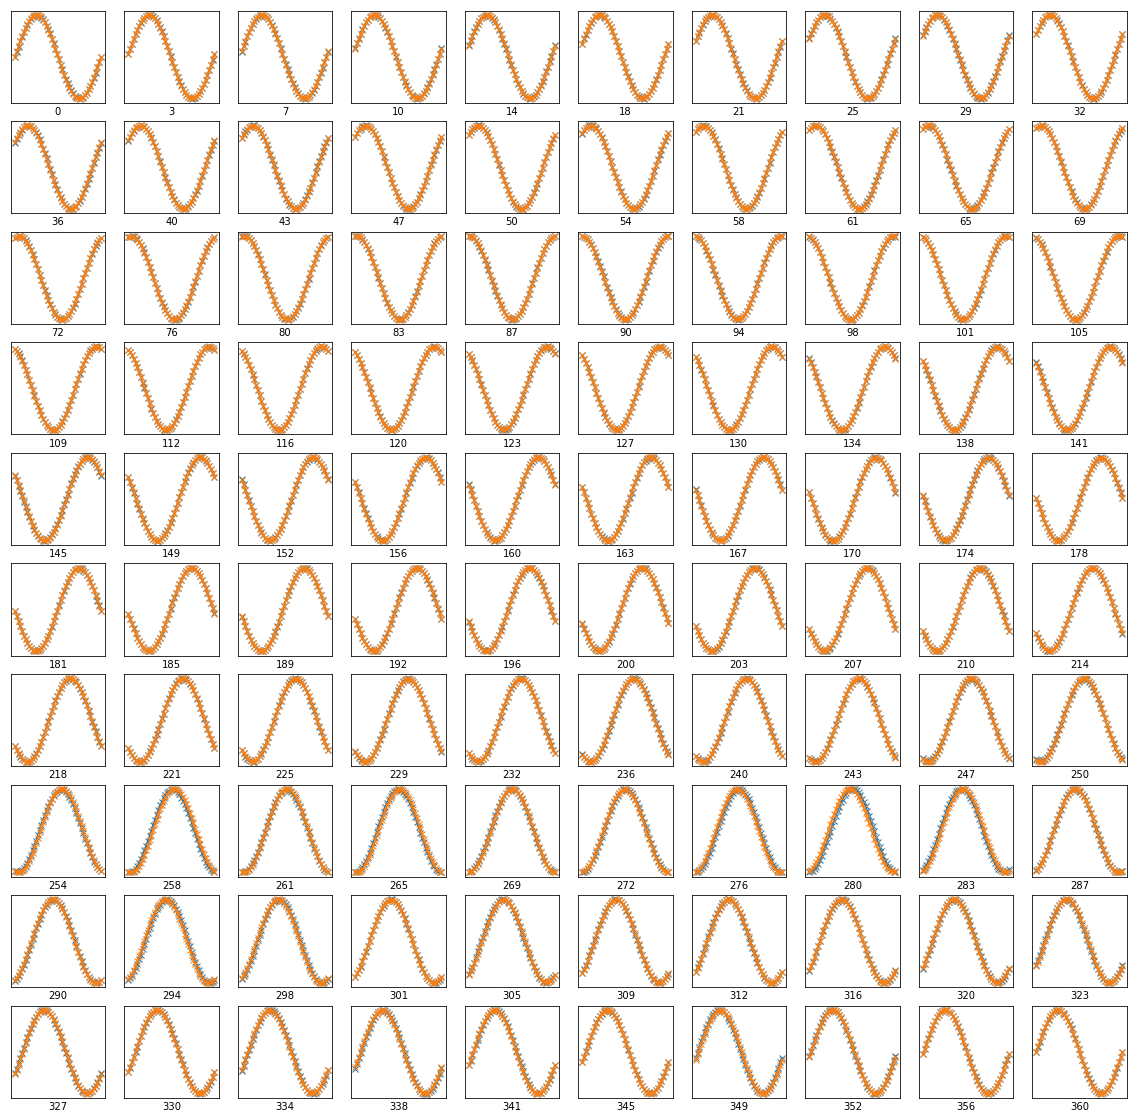

In [54]:
# Signal Reconstruction comparison
fig, ax = plt.subplots(10,10)
fig.set_figheight(20)
fig.set_figwidth(20)
for num_row, row in enumerate(ax):
    for num_col, col in enumerate(row):
        col.plot(time_range, predictions[np.ravel_multi_index((num_row,num_col),(10,10))],'-x')
        col.plot(time_range, signals[np.ravel_multi_index((num_row,num_col),(10,10))],'-x')
        col.set_xticks([])
        col.set_yticks([])
        col.set_xlabel(str(int(360*phase_range[np.ravel_multi_index((num_row,num_col),(10,10))]/(2*np.pi))))
        col.grid()
        

plt.show()
plt.savefig('Conv2DLatent2')

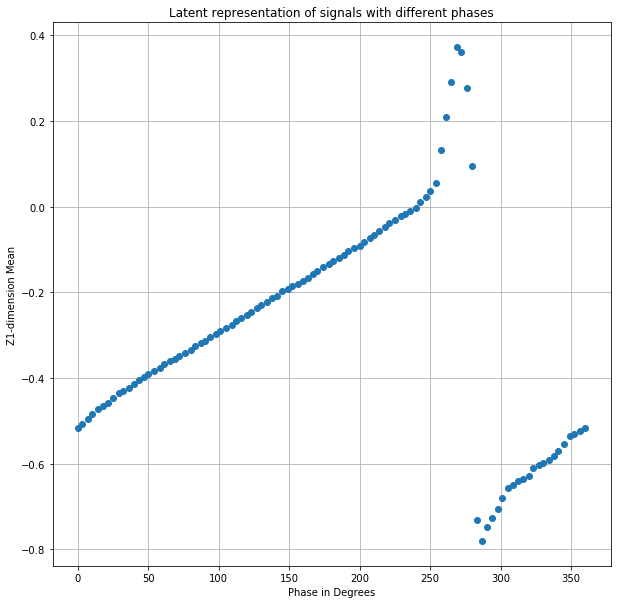

In [55]:
plt.figure(figsize = (10,10))
plt.errorbar((360*phase_range/(2*np.pi)).astype(int),x_train_encoded[:,0],yerr=np.exp(log_t)*np.ones(len(x_train_encoded[:,0])),
            fmt ='o')
plt.xlabel('Phase in Degrees')
plt.ylabel('Z1-dimension Mean')
plt.title('Latent representation of signals with different phases')
plt.grid()
plt.savefig('Mean Z1D Second')
# plt.figure(figsize = (10,10))
# plt.scatter((360*phase_range/(2*np.pi)).astype(int),x_train_encoded_sigma[:,0])
# plt.xlabel('Phase in Degrees')
# plt.ylabel('Z1-dimension logStd')
# plt.title('Latent representation of signals with different phases. Log of Standard Deviation.')
# plt.grid()
# plt.savefig('Log Std Z1D')

In [44]:
np.arange(len(x_train_encoded))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

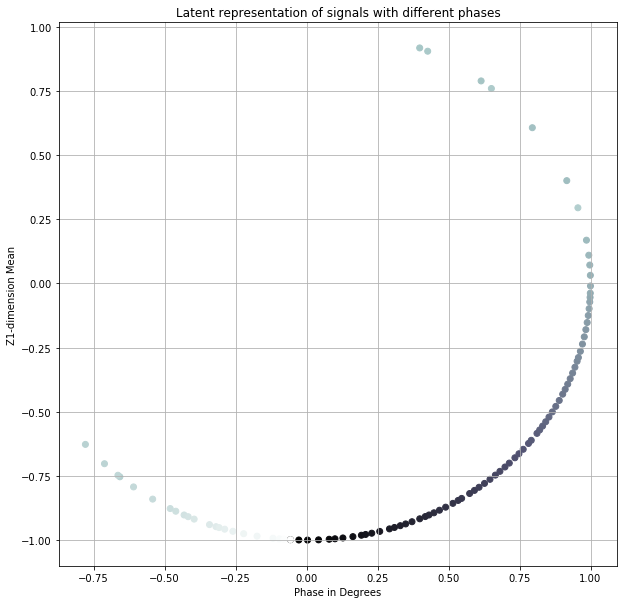

In [45]:
import matplotlib.cm as cm
plt.figure(figsize = (10,10))
plt.scatter(x_train_encoded_projected[:,0],x_train_encoded_projected[:,1], c = np.arange(len(x_train_encoded)), cmap = cm.bone)
plt.xlabel('Phase in Degrees')
plt.ylabel('Z1-dimension Mean')
plt.title('Latent representation of signals with different phases')
plt.grid()
plt.savefig('Mean Z1D')
# plt.figure(figsize = (10,10))
# plt.scatter((360*phase_range/(2*np.pi)).astype(int),x_train_encoded_sigma[:,0])
# plt.xlabel('Phase in Degrees')
# plt.ylabel('Z1-dimension logStd')
# plt.title('Latent representation of signals with different phases. Log of Standard Deviation.')
# plt.grid()
# plt.savefig('Log Std Z1D')

# Reload Models

In [92]:
root_model_folder = "C:\\Users\\Luis Pérez\\Documents\\Master\\TUE\\Final Project\\Python\\models\\HeatKernel2"
file_model = "2018-04-03-18-11__"
vae = load_model(win32api.GetShortPathName(join(root_model_folder,'vae',file_model)), 
                           custom_objects={'latent_dim':latent_dim,
                                           'batch_size': batch_size,
                                           'xent_loss': xent_loss,
                                           'vae_loss': vae_loss,
                                           'heat_loss': heat_loss,
                                           'epsilon_std':epsilon_std,
                                          'tf':tf,
                                          'L':L})
encoder = load_model(win32api.GetShortPathName(join(root_model_folder,'encoder',file_model)), 
                           custom_objects={'latent_dim':latent_dim,
                                           'batch_size': batch_size,
                                           'xent_loss': xent_loss,
                                           'vae_loss': vae_loss,
                                           'heat_loss': heat_loss,
                                           'epsilon_std':epsilon_std,
                                          'tf':tf,
                                          'L':L})

c:\anaconda3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
